# Part 2, Model 2A: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus images of the eye + selected patient details + calculated OC + calculated OD. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-10 23:13:10.317046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 23:13:10.317123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 23:13:10.416673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 23:13:10.611474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 23:13:12.162153: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


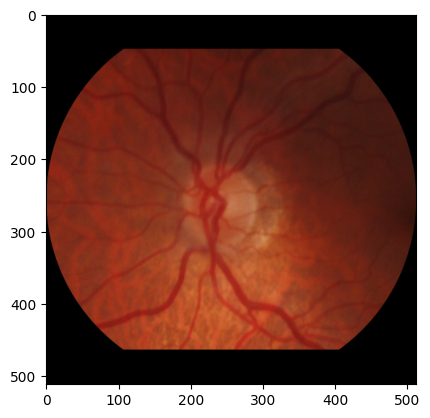

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

viewFundus(data['fundus'][12044])

In [11]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

data[['eye']].value_counts()

eye
1.0    2925
0.0    2808
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' is your original DataFrame

# Separate the data into numerical and non-numerical subsets
numerical_data = data.select_dtypes(include=[np.number])  # only numerical features

# Check and fill columns with all NaN values
for col in numerical_data.columns:
    if numerical_data[col].isna().all():
        numerical_data[col].fillna(0, inplace=True)  # or use another strategy

# Check the number of columns before imputation
print("Number of columns before imputation:", numerical_data.shape[1])

# Initialize the IterativeImputer with a RandomForestRegressor
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)

# Perform the imputation - fit and transform the numerical data
numerical_data_imputed = imp.fit_transform(numerical_data)

# Convert the imputed numerical data back to a pandas DataFrame
# Debugging: Check the shape of the imputed data
print("Shape of imputed data:", numerical_data_imputed.shape)

# Create the DataFrame using the original column names
# Here we're assuming that the columns should match the original
# If not, adjust the columns parameter accordingly
numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

# Combine the imputed numerical data back with the non-numerical data
non_numerical_data = data.select_dtypes(exclude=[np.number])  # reselect to include changes
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

# Ensure the order of rows remains the same
data_imputed = data_imputed.loc[data.index]

Number of columns before imputation: 25
Shape of imputed data: (12449, 25)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [15]:
print(data_imputed.describe())

              types  isColor        gender           age           eye  \
count  12449.000000  12449.0  12449.000000  12449.000000  12449.000000   
mean       0.372239      1.0      0.434894     56.950322      0.566712   
std        0.505039      0.0      0.495763      8.813494      0.495549   
min       -1.000000      1.0      0.000000      1.000000      0.000000   
25%        0.000000      1.0      0.000000     50.430000      0.000000   
50%        0.000000      1.0      0.000000     60.150000      1.000000   
75%        1.000000      1.0      1.000000     60.150000      1.000000   
max        1.000000      1.0      1.000000     91.000000      1.000000   

                sbp           dbp            hr           iop          vcdr  \
count  12449.000000  12449.000000  12449.000000  12449.000000  12449.000000   
mean     163.589479     75.231811     61.311538     12.190373      0.640205   
std       45.207050     11.353199      7.083531      2.237559      0.113754   
min      107.0000

In [16]:
data_imputed[["eye"]].value_counts()

eye
1.0    7055
0.0    5394
Name: count, dtype: int64

In [17]:
data_imputed['eye'] = data_imputed['eye'].round().astype(int)

In [18]:
data_imputed[["eye"]].value_counts()

eye
1      7055
0      5394
Name: count, dtype: int64

In [19]:
data = data_imputed

data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0.0,1.0,0.0,58.00,0,317.82,85.23,65.27,14.29,0.389440,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.0,60.00,1,119.58,66.28,66.21,12.65,0.652206,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,66.00,1,123.12,70.29,81.54,14.60,0.661604,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1.0,0.0,70.00,0,323.50,86.13,64.73,14.69,0.390486,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,45.00,1,132.05,85.01,56.67,19.13,0.520532,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0.0,1.0,0.0,50.43,0,197.09,83.37,64.38,11.14,0.556525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0.0,1.0,0.0,50.43,0,197.09,83.37,64.38,11.14,0.556525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0.0,1.0,0.0,50.43,0,197.09,83.37,64.38,11.14,0.556525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0.0,1.0,0.0,50.43,0,197.09,83.37,64.38,11.14,0.556525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
data = data[
    
    (data['fundus'].notnull()) & (data['types'] != -1)
    
]

fundus_subset = data[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


/tmp/ipykernel_405/3636307318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_405/3636307318.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_405/3636307318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [21]:
fundus_subset['types'].value_counts()

types
0.0    7549
1.0    4767
Name: count, dtype: int64

In [22]:
fundus_subset

,types,fundus,names,combined
0,0.0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0.0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0.0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0.0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0.0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0.0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0.0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0.0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0.0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [23]:
# from sklearn.model_selection import StratifiedShuffleSplit

# # Assuming fundus_subset is your DataFrame and 'types' is the column with labels
# # Also assuming you have 'fundus_subset_random' DataFrame created earlier

# testSize = 200
# valSize = 200

# # Calculate the number of samples for each class
# glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
# healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

# print("this is the glaucoma count", glaucomaCount)
# print("this is the healthy eyes count", healthyCount)

# print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

# # Set the random seed for reproducibility
# random_state = 1

# # Create StratifiedShuffleSplit instance for test set
# stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

# for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
#     train_set = fundus_subset.iloc[train_index]
#     test = fundus_subset.iloc[test_index]

# # Create StratifiedShuffleSplit instance for validation set
# stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

# for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
#     train = train_set.iloc[train_index]
#     val = train_set.iloc[val_index]

# # Now train_set_final, val_set, and test_set contain the stratified splits

# # Print the counts for each set
# print("\nTrain set size:", len(train))
# print("Validation set size:", len(val))
# print("Test set size:", len(test))

# # You can access the features and labels as needed:
# train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
# train_labels = train['types']
# val_features = val.drop('types', axis=1)
# val_labels = val['types']
# test_features = test.drop('types', axis=1)
# test_labels = test['types']

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1.0'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0.0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

# Set the percentages for the test and validation splits
test_percentage = 0.20  # 20% of the data for testing
val_percentage_from_train = 0.15  # 25% of the remaining data after test split for validation

# Assuming fundus_subset is your DataFrame and 'types' is the column with labels

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set with percentage
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Note: Adjusted validation split to calculate percentage from the remaining train set
# Create StratifiedShuffleSplit instance for validation set with percentage
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

# Print the counts for each set and total
print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# You can access the features and labels as needed
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549

Total fundus images to be used: 12316

Train set size: 8374
Validation set size: 1478
Test set size: 2464


In [25]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  8374
Test Size:  2464


In [26]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-10 23:14:08.570447: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:08.841344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:08.841791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 512
batchSize = 10

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-02-10 23:14:08.859516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:08.859966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:08.860381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:09.213825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 23:14:09.214219: I external/local_xla/xla/stream_executor

Found 8374 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.
Found 2464 validated image filenames belonging to 2 classes.


In [28]:
# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0.0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1.0']

with tf.device('/GPU:0'):

    # Set class mode to 'sparse' for visualization data generators
    classes = 'sparse'

    # Create data generators for healthy and glaucoma subsets for visualization
    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [29]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

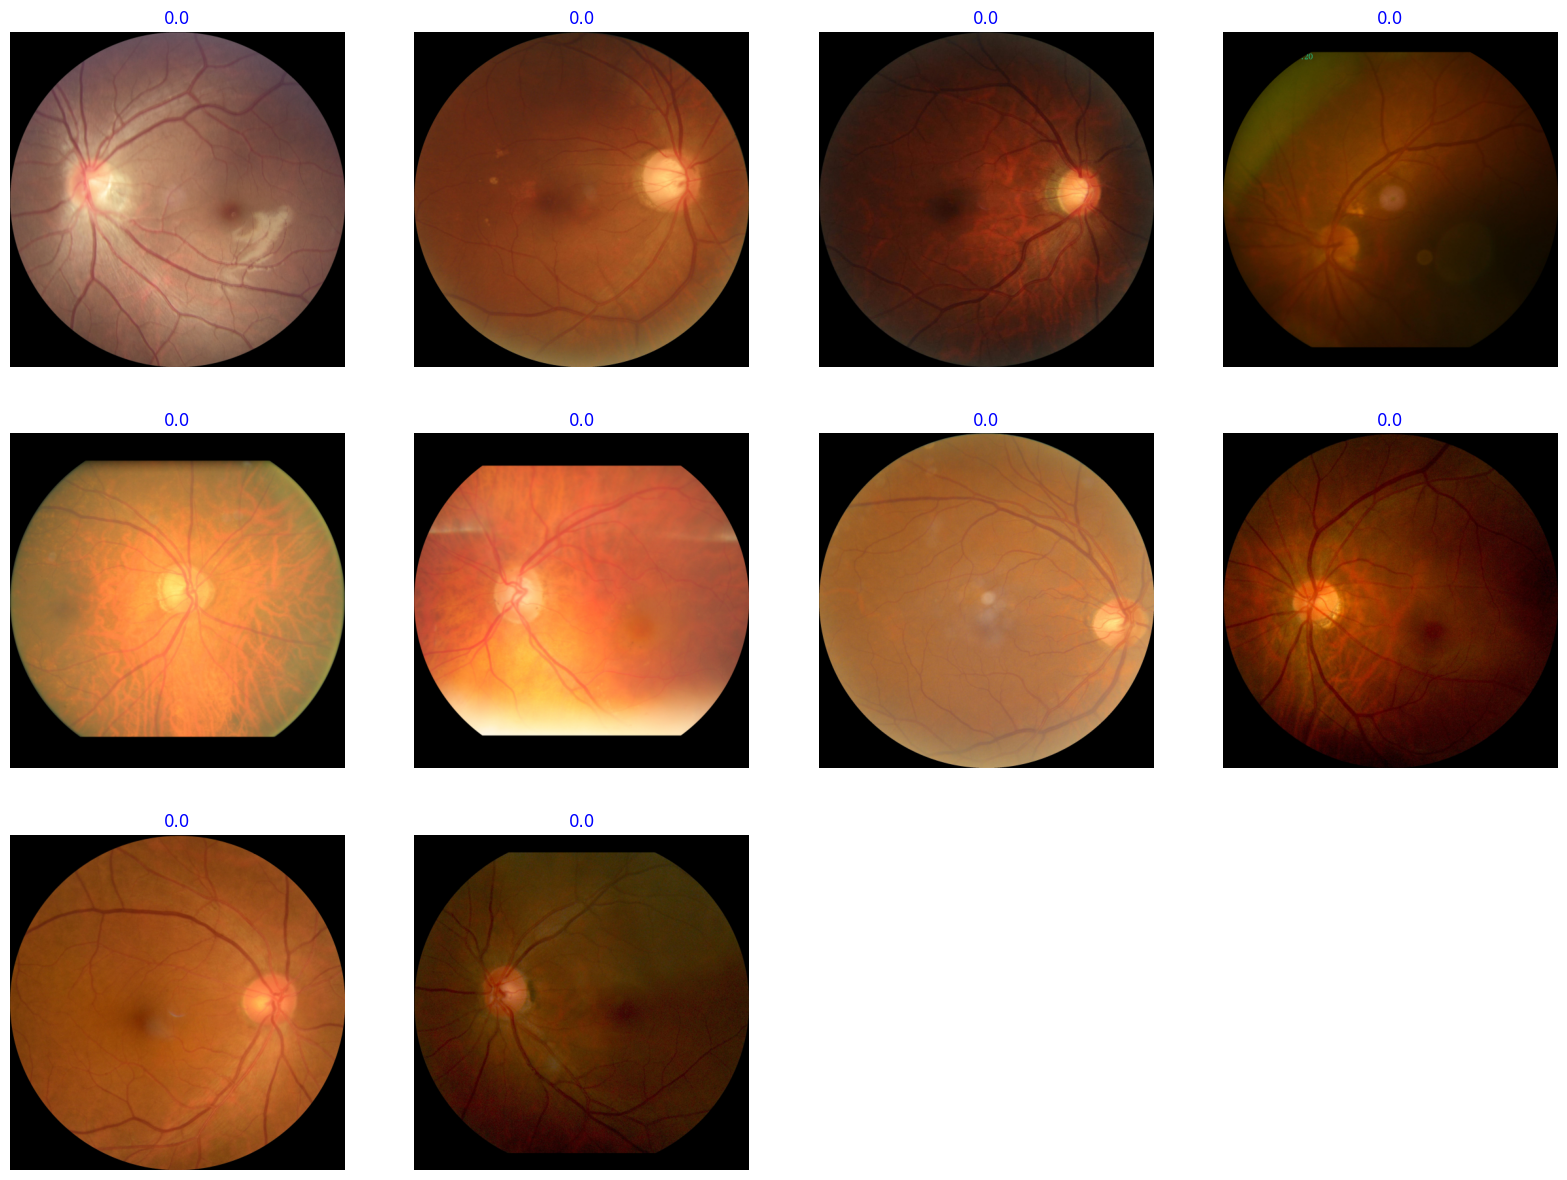

In [30]:
show_images(healthy_subset_Gen)

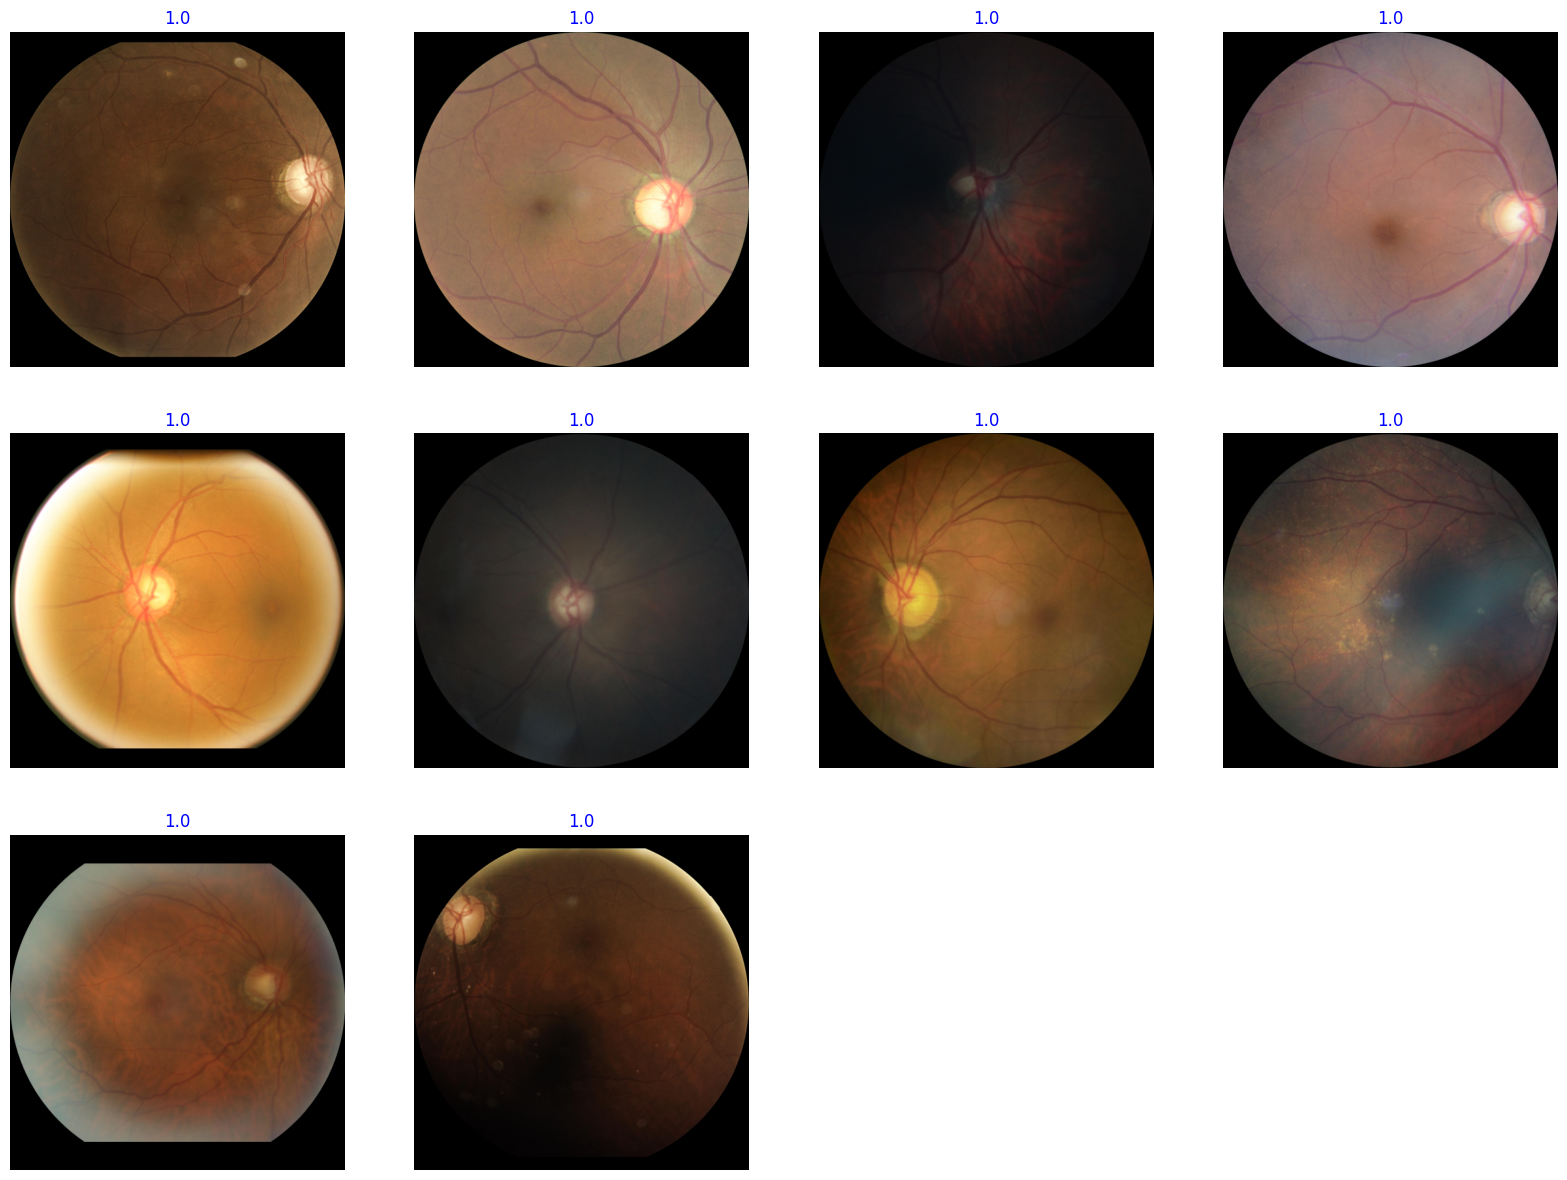

In [31]:
show_images(glaucoma_subset_Gen)

In [32]:
# from keras.applications import MobileNetV3Small
# from keras import Sequential

# # Load pre-trained MobileNetV3 model
# base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

# model = Sequential([
#     base_model, layers.GlobalAveragePooling2D()
# ])

# # Function to extract features using this model
# def extract_features(generator, sample_count):
#     features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
#     labels = np.zeros(shape=(sample_count))
#     i = 0
#     for inputs_batch, labels_batch in generator:
#         features_batch = model.predict(inputs_batch)
#         features[i * batchSize: (i + 1) * batchSize] = features_batch
#         labels[i * batchSize: (i + 1) * batchSize] = labels_batch
#         i += 1
#         if i * batchSize >= sample_count:
#             break
#     return features, labels

In [33]:
from keras.applications import InceptionV3
from keras import Sequential
from keras.layers import GlobalAveragePooling2D
import numpy as np

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target, target, 3))

# Assemble the sequential model with GlobalAveragePooling
model = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_features(generator, sample_count, batchSize):
    # Initialize a zeros array for features and labels
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    # Loop over the data generator
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        batch_size = inputs_batch.shape[0]  # Get the actual batch size of the inputs
        # If the total number of samples processed + current batch size is greater than sample_count,
        # adjust the batch_size to fit what's remaining
        # This happens on the last batch if sample_count isn't a multiple of batchSize
        if (i * batchSize + batch_size) > sample_count:
            batch_size = sample_count - (i * batchSize)
        features[i * batchSize: i * batchSize + batch_size] = features_batch[:batch_size]
        labels[i * batchSize: i * batchSize + batch_size] = labels_batch[:batch_size]
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels


In [34]:
import numpy as np

# Define a function to concatenate non-image features to the extracted features
def combine_features(extracted_features, labels, generator_indices, non_image_data):
    # Get the non-image features for the corresponding indices
    non_image_features = non_image_data.iloc[generator_indices].to_numpy()

    # Concatenate the image features with the non-image features
    combined_features = np.concatenate((extracted_features, non_image_features), axis=1)
    
    return combined_features, labels

# Extract image features as you've done before
train_features, train_labels = extract_features(trainGen, trainGen.samples, 10)
val_features, val_labels = extract_features(valGen, valGen.samples, 10)
test_features, test_labels = extract_features(testGen, testGen.samples, 10)

# Select the non-image features from your dataframe
non_image_features = data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']]

# Combine the extracted image features with the non-image features
train_features_combined, train_labels = combine_features(train_features, train_labels, trainGen.index_array, non_image_features)
val_features_combined, val_labels = combine_features(val_features, val_labels, valGen.index_array, non_image_features)
test_features_combined, test_labels = combine_features(test_features, test_labels, testGen.index_array, non_image_features)

2024-02-10 23:15:07.813225: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-10 23:15:08.172593: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 55ms/step


2024-02-10 23:18:17.948314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31457280 bytes after encountering the first element of size 31457280 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 28ms/step


In [35]:
# import numpy as np

# train_features, train_labels = extract_features(trainGen, trainGen.samples, 10)
# val_features, val_labels = extract_features(valGen, valGen.samples, 10)
# test_features, test_labels = extract_features(testGen, testGen.samples, 10)

In [36]:
train_features_combined

array([[2.33553257e-02, 3.70054357e-02, 0.00000000e+00, ...,
        1.25400000e+01, 5.72000000e-01, 7.89875000e-01],
       [9.28595569e-03, 7.33900666e-02, 0.00000000e+00, ...,
        1.11400000e+01, 5.56525167e-01, 7.87325000e-01],
       [3.89122143e-02, 2.06701770e-01, 6.43637322e-04, ...,
        1.86200000e+01, 5.92099433e-01, 7.50775000e-01],
       ...,
       [3.84488814e-02, 1.68280467e-01, 0.00000000e+00, ...,
        1.49400000e+01, 6.50443167e-01, 6.82550000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.17200000e+01, 5.14404276e-01, 8.45450000e-01],
       [2.73637287e-02, 2.61885762e-01, 5.05068786e-02, ...,
        1.47600000e+01, 6.09382900e-01, 6.99125000e-01]])

In [37]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    # Create and train the SVM
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(train_features_combined, train_labels)

In [38]:
# Validate the SVM
val_accuracy = svm_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the SVM
test_accuracy = svm_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7949932341001353
Test accuracy: 0.7800324675324676


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1286  224]
 [ 318  636]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83      1510
         1.0       0.74      0.67      0.70       954

    accuracy                           0.78      2464
   macro avg       0.77      0.76      0.76      2464
weighted avg       0.78      0.78      0.78      2464



In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features_combined, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [41]:
# Validate the KNN
val_accuracy = knn_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the KNN
test_accuracy = knn_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7442489851150202
Test accuracy: 0.7378246753246753


In [42]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1295  215]
 [ 431  523]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80      1510
         1.0       0.71      0.55      0.62       954

    accuracy                           0.74      2464
   macro avg       0.73      0.70      0.71      2464
weighted avg       0.73      0.74      0.73      2464



In [43]:
import xgboost as xgb

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features_combined, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [44]:
# Validate the xgb model
val_accuracy = xgb_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the xgb model
test_accuracy = xgb_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.8024357239512855
Test accuracy: 0.7857142857142857


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1331  179]
 [ 349  605]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      1510
         1.0       0.77      0.63      0.70       954

    accuracy                           0.79      2464
   macro avg       0.78      0.76      0.77      2464
weighted avg       0.78      0.79      0.78      2464



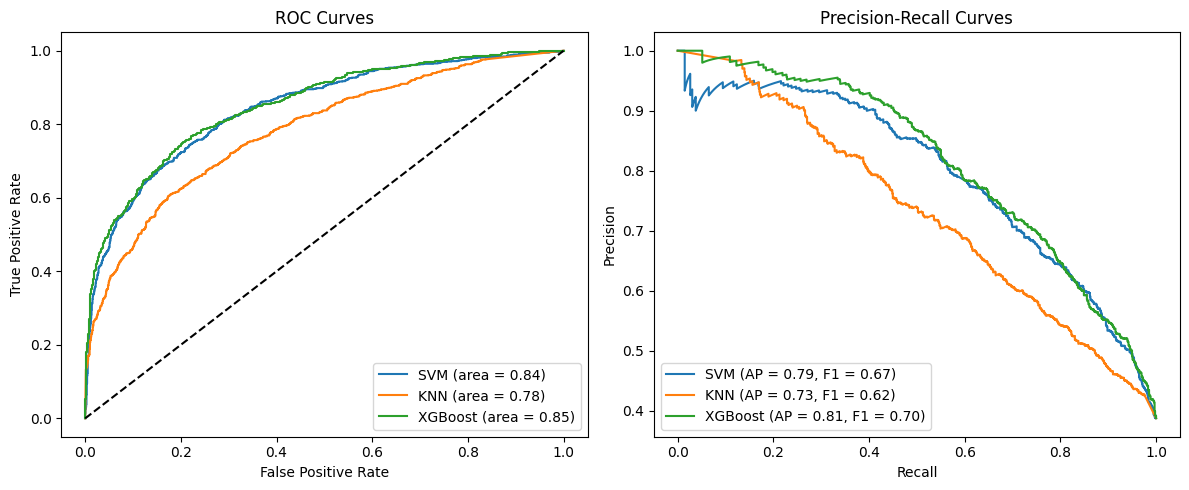

In [46]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted probabilities for each model
true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]

# KNN probabilities
knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]

# XGBoost probabilities
xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate Precision-Recall curve and F1 score for each model
precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

# Plot all ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot all Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [47]:
# # Plot the confusion matrix heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title('Confusion Matrix Heatmap')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

In [48]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# # define sequential model
# svm_model = Sequential()
# # define conv-pool layers - set 1
# svm_model.add(Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid', input_shape = (224, 224, 3)))
# svm_model.add(BatchNormalization(axis=3))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # define conv-pool layers - set 2
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))

# svm_model.add(MaxPooling2D(pool_size=(2, 2)))

# # define conv-pool layers - set 3
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # add flatten layer
# svm_model.add(Flatten())

# # add dense layers with some dropout
# svm_model.add(Dense(512, activation='relu'))
# svm_model.add(Dropout(rate = 0.2))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(128, activation='relu'))

# # add output layer
# svm_model.add(Dense(1, kernel_regularizer = l2(0.01), activation='linear'))

# svm_model.summary()

In [49]:
# from keras.callbacks import TensorBoard, EarlyStopping
# from datetime import datetime

# logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [50]:
# from keras.backend import epsilon

# def f1_score_metric(y_true, y_pred):
#     y_pred = tf.round(y_pred)
#     return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + epsilon())

In [51]:
# with tf.device('/GPU:0'):

#     svm_model.compile(optimizer = 'adam',
#                 loss = 'squared_hinge',
#                 metrics=['accuracy','Precision','Recall','AUC',f1_score_metric])

#     r=svm_model.fit(trainGen,
#                 batch_size = 32,
#                 verbose = 1,
#                 epochs = 10,
#                 validation_data = valGen,
#                 callbacks = [tensorboard_callback, es],)

In [52]:
# # Evaluate the model on the validation data
# score=svm_model.evaluate(valGen)
# score

In [53]:
# # Plot the training and validation accuracy and loss
# import seaborn as sns
# sns.set()

# acc = r.history['accuracy']
# val_acc = r.history['val_accuracy']
# loss = r.history['loss']
# val_loss = r.history['val_loss']
# epochs = range(1, len(loss) + 1)

# #accuracy plot
# plt.plot(epochs, acc, color='green', label='Training Accuracy')
# plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# plt.figure()
# #loss plot
# plt.plot(epochs, loss, color='green', label='Training Loss')
# plt.plot(epochs, val_loss, color='red', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [54]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Generate predictions
# predictions = svm_model.predict(testGen)
# predictions = np.round(predictions).astype(int).flatten()  # Adjust based on your output format

# # Get true labels
# true_labels = testGen.labels

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy}")

# # Generate and print confusion matrix
# conf_matrix = confusion_matrix(true_labels, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate and print classification report
# class_report = classification_report(true_labels, predictions)
# print("Classification Report:")
# print(class_report)